In [71]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
import copy
warnings.simplefilter(action="ignore")
import pickle
import wrds

In [72]:
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")
db = ADatabase("sapling")

In [73]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [74]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",np.nan)
market_yield.dropna(inplace=True)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy = processor.column_date_processing(spy)
spy = spy.sort_values("date")
fred.disconnect()

In [75]:
unneeded_columns = ["ticker","year","quarter","gsector","gicdesc","y"]

In [76]:
market.connect()
sec.connect()
factors_df = []
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = processor.column_date_processing(sec.query("financials",{"ticker":ticker})).drop(["gsector","gicdesc"],axis=1)
        filings["year"] = [x.year for x in filings["date"]]
        filings["quarter"] = [x.quarter for x in filings["date"]]
        filings["quarter"] = filings["quarter"].shift(1)
        price = price.drop(["date","ticker"],axis=1).merge(filings.drop(["date","ticker"],axis=1),on=["year","quarter"],how="left").groupby(["year","quarter"]).mean().reset_index()
        price["ticker"] = ticker
        price["y"] = price["adjclose"].shift(-4)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()

  4%|█████████▋                                                                                                                                                                                                                              | 21/503 [00:02<00:45, 10.52it/s]

GOOGL 'date'


 11%|████████████████████████▉                                                                                                                                                                                                               | 54/503 [00:06<00:59,  7.52it/s]

AVB 'date'


 13%|█████████████████████████████▌                                                                                                                                                                                                          | 64/503 [00:07<00:43, 10.19it/s]

BRK.B 'date'


 16%|████████████████████████████████████▍                                                                                                                                                                                                   | 79/503 [00:09<00:38, 10.98it/s]

BF.B 'date'


 16%|█████████████████████████████████████▎                                                                                                                                                                                                  | 81/503 [00:09<00:39, 10.81it/s]

BXP 'date'


 18%|█████████████████████████████████████████▉                                                                                                                                                                                              | 91/503 [00:10<00:37, 10.92it/s]

CCL 'date'


 26%|████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 132/503 [00:15<00:34, 10.72it/s]

CPAY 'date'


 29%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 144/503 [00:16<00:35, 10.24it/s]

DAY 'date'


 30%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 150/503 [00:17<00:34, 10.21it/s]

DLR 'date'


 36%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 180/503 [00:20<00:33,  9.57it/s]

EQR 'date'
ESS 'date'


 37%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 184/503 [00:20<00:27, 11.59it/s]

EG 'date'


 39%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 195/503 [00:22<00:33,  9.21it/s]

FRT 'date'


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 214/503 [00:24<00:24, 11.79it/s]

GEV 'date'


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 261/503 [00:29<00:24,  9.77it/s]

IVZ 'date'
INVH 'date'


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 270/503 [00:30<00:25,  9.10it/s]

JCI 'date'


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 280/503 [00:31<00:20, 10.68it/s]

KIM 'date'


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 299/503 [00:33<00:19, 10.37it/s]

LYB 'date'


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 323/503 [00:36<00:17, 10.52it/s]

MAA 'date'


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 349/503 [00:39<00:16,  9.47it/s]

NCLH 'date'


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 354/503 [00:39<00:15,  9.79it/s]

NXPI 'date'


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 399/503 [00:45<00:10,  9.60it/s]

REG 'date'


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 409/503 [00:46<00:09,  9.44it/s]

RCL 'date'


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 413/503 [00:46<00:09,  9.94it/s]

SLB 'date'


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 460/503 [00:51<00:03, 11.16it/s]

UDR 'date'


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 471/503 [00:53<00:03,  8.15it/s]

VLTO 'date'


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 477/503 [00:53<00:02, 11.66it/s]

VICI 'date'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:56<00:00,  8.89it/s]

ZTS 'date'


In [77]:
factors_df = pd.concat(factors_df)

In [78]:
for column in factors_df:
    if column in factors_df[column]:
        factors_df.drop(column,axis=1,inplace=True)

In [79]:
factors_df = factors_df.fillna(0)

In [124]:
model = XGBRegressor()
factors = ["ptb","roa","mktcap","bm","short_debt","volume","divyield","adjclose"]
factors_df.sort_values(["year","quarter"],inplace=True)
training_data = factors_df[(factors_df["year"]<2020)].dropna()
sim = factors_df[factors_df["year"]>=2020].drop("y",axis=1).dropna()
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])

In [125]:
prices = []
market.connect()
db.cloud_connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left")
        price = price.merge(spy[["date","spy"]],on="date",how="left")
        price = price.merge(market_yield[["date","rf"]],on="date",how="left")
        price = price.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
        price["expected_return"] = (price["prediction"] - price["adjclose"]) / price["adjclose"]
        price["historical_return"] = price["adjclose"].pct_change(90)
        price["factor_return"] = price["spy"].pct_change(90)
        price["cov"] = price["factor_return"].rolling(100).cov(price["expected_return"])
        price["var"] = price["factor_return"].rolling(100).var()
        price["beta"] = price["cov"] / price["var"]
        price["excess_return"] = price["rf"] + price["beta"] * (price["expected_return"] - price["rf"])
        price["sigma"] = price["adjclose"].rolling(262).std()
        prices.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
db.disconnect()

 13%|█████████████████████████████▉                                                                                                                                                                                                          | 65/503 [00:05<00:30, 14.18it/s]

BRK.B 'date'


 16%|████████████████████████████████████▉                                                                                                                                                                                                   | 80/503 [00:06<00:30, 13.97it/s]

BF.B 'date'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:40<00:00, 12.49it/s]

ZTS 'date'


In [126]:
sim = pd.concat(prices).dropna()
sim["quarter"] = [x.quarter for x in sim["date"]]
sim = sim[sim["date"]>datetime(2022,1,1)]

In [127]:
# Initialize variables
structure = {"stock":0.5,"bond":0.4,"option":0.1}
start = sim["date"].min()
end = sim["date"].max()
date = start
number_of_stocks = 1
portfolio = {
    "date": date,
    "tax": 0,
    "fees": 0,
    "cash": 100000,
    "positions": [
        {
            
            "stocks": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
            "bonds": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
            "options": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)]
        }
        for _ in sp500["GICS Sector"].unique()
    ]
}
states = []
trades = []
annual_balance = 100000
prev_quarter = 0
quarter = 1
for date in sim.sort_values("date")["date"].unique():
    today = sim[sim["date"] == date].copy()
    prev_quarter = quarter
    quarter = date.quarter
    if today.index.size > 0:
        try:
            portfolio = copy.deepcopy(portfolio)
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = copy.deepcopy(portfolio["positions"])
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                options = copy.deepcopy(position["options"])
                bonds = copy.deepcopy(position["bonds"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    bond = bonds[j]
                    option = options[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        row = today[today["ticker"] == ticker].iloc[0]
                        stock = Stock.update(row, stock)
                        position["stocks"][j] = stock
                        bond = Bond.update(row, bond)
                        position["bonds"][j] = bond
                        option = Option.update(row, option)
                        position["options"][j] = option
                positions[i] = position
            portfolio["positions"] = positions
            
            cash = portfolio["cash"]
            positions = copy.deepcopy(portfolio["positions"])
            
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                options = copy.deepcopy(position["options"])
                bonds = copy.deepcopy(position["bonds"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    bond = bonds[j]
                    option = options[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        notional = stock["pv"] + option["pv"] + bond["pv"]
                        hpr = int((date - stock["buy_date"]).days)
                        opportunity_row = today[today["GICS Sector"] == sector].sort_values("expected_return", ascending=False).iloc[j]
                        opportunity_ticker = opportunity_row["ticker"]
                        if (hpr > 90):
                            row = today[today["ticker"] == ticker].iloc[0]
                            stock = Stock.sell(row, stock)
                            position["stocks"][j] = stock
                            trades.append(stock)
                            stock = Stock.buy(opportunity_row, stock, notional * structure["stock"])
                            stock["sector"] = sector
                            position["stocks"][j] = stock
                            option = Option.sell(row, option)
                            position["options"][j] = option
                            trades.append(option)
                            option = Option.buy(opportunity_row, option, notional * structure["option"])
                            option["sector"] = sector
                            position["options"][j] = option
                            bond = Bond.sell(row, bond)
                            position["bonds"][j] = bond
                            trades.append(bond)
                            bond = Bond.buy(opportunity_row, bond, notional * structure["bond"])
                            bond["sector"] = sector
                            position["bonds"][j] = bond
                            positions[i] = position
                portfolio["positions"] = positions
            if date == sim["date"].min():
                for i in range(11):
                    notional = float(cash / 11 / number_of_stocks)
                    position = positions[i]
                    sector = list(sp500["GICS Sector"].unique())[i]
                    stocks = copy.deepcopy(position["stocks"])
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        row = today[today["GICS Sector"] == sector].sort_values("expected_return", ascending=False).iloc[j]
                        stock = Stock.buy(row, stock, notional * structure["stock"])
                        stock["sector"] = sector
                        position["stocks"][j] = stock
                        option = Option.buy(row, option, notional * structure["option"])
                        option["sector"] = sector
                        position["options"][j] = option
                        bond = Bond.buy(row, bond, notional * structure["bond"])
                        bond["sector"] = sector
                        position["bonds"][j] = bond
                    positions[i] = position
                portfolio["positions"] = positions
                portfolio["cash"] = 0
            states.append(copy.deepcopy(portfolio))
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

In [128]:
portfolios = []
for state in states:
    for i in range(11):
        for j in range(number_of_stocks):
            for asset_class in ["stocks","bonds","options"]:
                view = state["positions"][i][asset_class][j]
                view["date"] = state["date"]
                view["asset_class"] = asset_class
            portfolios.append(state["positions"][i]["stocks"][j])
            portfolios.append(state["positions"][i]["options"][j])
            portfolios.append(state["positions"][i]["bonds"][j])

In [129]:
performance = pd.DataFrame(portfolios).pivot_table(index=["date","sector"],columns="asset_class",values="pv").reset_index().sort_values("date")
performance = performance.groupby(["date","sector"]).agg({"stocks":"sum","bonds":"sum","options":"sum"}).reset_index()
# performance["stock_return"] = (performance["pv"] - performance["pv"].iloc[0]) / performance["pv"].iloc[0]

In [130]:
performance

asset_class,date,sector,stocks,bonds,options
0,2022-01-03,Communication Services,4545.454545,3636.363636,909.090909
1,2022-01-03,Consumer Discretionary,4545.454545,3636.363636,909.090909
2,2022-01-03,Consumer Staples,4545.454545,3636.363636,909.090909
3,2022-01-03,Energy,4545.454545,3636.363636,909.090909
4,2022-01-03,Financials,4545.454545,3636.363636,909.090909
...,...,...,...,...,...
7464,2024-09-19,Industrials,8620.745086,6116.338674,1544.078267
7465,2024-09-19,Information Technology,20308.822105,15509.239509,4050.921372
7466,2024-09-19,Materials,10667.363862,7504.081905,1886.490610
7467,2024-09-19,Real Estate,4965.885596,3398.595345,849.648836


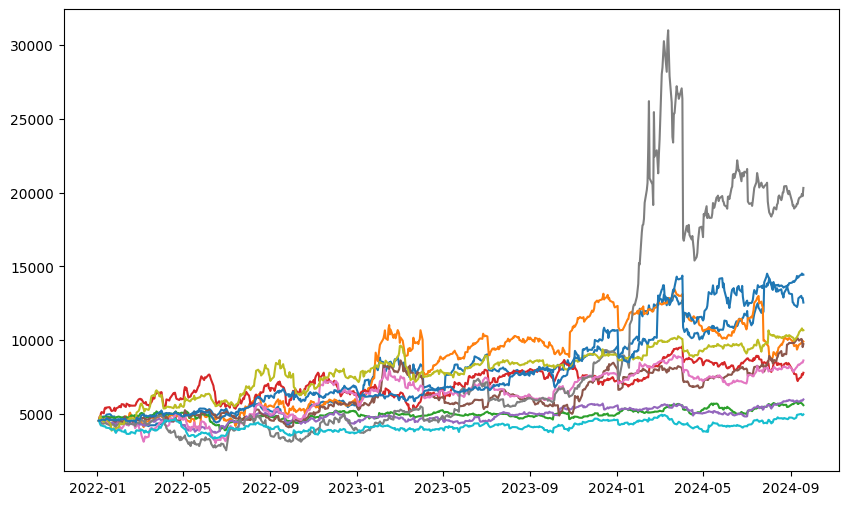

In [131]:
plt.figure(figsize=(10, 6))  
for sector in performance["sector"].unique():
    sector_perf = performance[performance["sector"]==sector]
    plt.plot(sector_perf["date"].values,sector_perf["stocks"].values)
    # plt.legend(performance["sector"].unique())
plt.show()

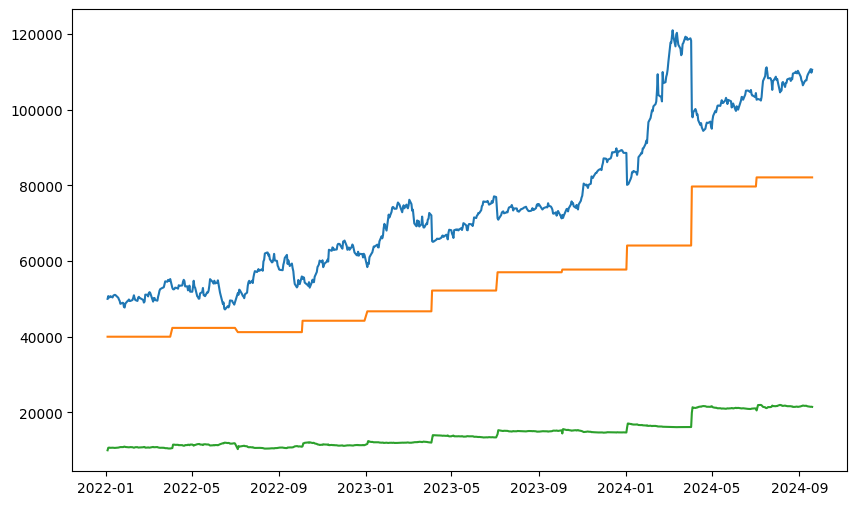

In [132]:
performance = performance.groupby(["date"]).agg({"stocks":"sum","bonds":"sum","options":"sum"}).reset_index()
plt.figure(figsize=(10, 6)) 
plt.plot(performance["date"].values,performance["stocks"].values)
plt.plot(performance["date"].values,performance["bonds"].values)
plt.plot(performance["date"].values,performance["options"].values)
plt.show()

In [133]:
visualization = performance.merge(spy,on="date",how="left")
visualization = visualization.merge(market_yield[["date","rf"]],on="date",how="left")

In [134]:
visualization["pv"] = visualization["stocks"] + visualization["bonds"] + visualization["options"]
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]
visualization["ir_return"] = (visualization["rf"] - visualization["rf"].iloc[0]) / visualization["rf"].iloc[0]

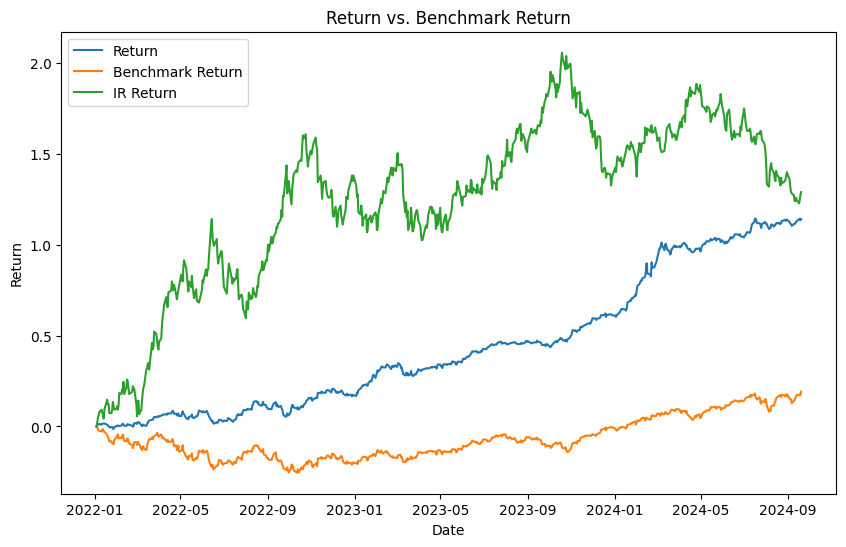

In [135]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the data
plt.plot(visualization["date"].values, visualization["return"], label="Return")
plt.plot(visualization["date"].values, visualization["benchmark_return"], label="Benchmark Return")
plt.plot(visualization["date"].values, visualization["ir_return"], label="IR Return")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Return vs. Benchmark Return")
plt.legend()

# Show the plot
plt.show()


In [136]:
(visualization["return"].iloc[-1] - visualization["benchmark_return"].iloc[-1]) / visualization["return"].std()

2.570778637645673

In [137]:
t = pd.DataFrame(trades).merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
t["return"] = (t["adjclose"] - t["buy_price"]) / t["buy_price"]
t["hpr"] = t["sell_date"] - t["buy_date"]
t["hpr"] = [int(x.days) for x in t["hpr"]]

In [138]:
t.sort_values("return",ascending=False).head(30)

,ticker,adjclose,quantity,excess_return,buy_price,buy_date,sell_date,pv,sector,strike_price,premium,contract_price,notional,return,rate,GICS Sector,hpr
270,SMCI,1015.570000,26.085982,0.050777,280.640000,2024-01-03,2024-04-03,26492.140630,Information Technology,NaN,NaN,NaN,NaN,2.618764,NaN,Information Technology,91
150,TSLA,192.580000,51.424547,-0.697669,108.100000,2023-01-03,2023-04-04,9903.339196,Consumer Discretionary,NaN,NaN,NaN,NaN,0.781499,NaN,Consumer Discretionary,91
273,CEG,189.599887,76.634524,-0.236210,115.221884,2024-01-03,2024-04-03,14529.896976,Utilities,NaN,NaN,NaN,NaN,0.645520,NaN,Utilities,91
156,WBD,15.150000,553.532610,0.180173,9.540000,2023-01-03,2023-04-04,8386.019048,Communication Services,NaN,NaN,NaN,NaN,0.588050,NaN,Communication Services,91
171,NVDA,42.299278,168.595810,-0.508200,27.438574,2023-04-04,2023-07-05,7131.480984,Information Technology,NaN,NaN,NaN,NaN,0.541599,NaN,Information Technology,92
237,CRWD,244.360000,35.850101,-1.848967,164.050000,2023-10-04,2024-01-03,8760.330780,Information Technology,NaN,NaN,NaN,NaN,0.489546,NaN,Information Technology,91
288,META,505.763738,25.606810,0.417673,343.439461,2024-01-03,2024-04-03,12950.996028,Communication Services,NaN,NaN,NaN,NaN,0.472643,NaN,Communication Services,91
240,AES,18.380369,568.648965,0.303687,12.675606,2023-10-04,2024-01-03,10451.978003,Utilities,NaN,NaN,NaN,NaN,0.450058,NaN,Utilities,91
75,PCG,14.165571,498.235727,-0.335498,9.823060,2022-07-05,2022-10-04,7057.793785,Utilities,NaN,NaN,NaN,NaN,0.442073,NaN,Utilities,91
30,HES,106.340170,61.311155,-0.069739,74.137480,2022-01-03,2022-04-04,6519.838696,Energy,NaN,NaN,NaN,NaN,0.434365,NaN,Energy,91


In [139]:
t.groupby(["GICS Sector"]).agg({"return":"mean","hpr":"mean"}).reset_index().sort_values("return").tail(50)

,GICS Sector,return,hpr
9,Real Estate,-0.026924,91.2
2,Consumer Staples,0.013976,91.2
4,Financials,0.016280,91.2
5,Health Care,0.100218,91.2
6,Industrials,0.103580,91.2
3,Energy,0.131975,91.2
8,Materials,0.148985,91.2
0,Communication Services,0.195048,91.2
1,Consumer Discretionary,0.200235,91.2
10,Utilities,0.213779,91.2
